In [1]:
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn. feature_selection import train_test_split
import numpy as np
import string

/opt/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [2]:
data= np.loadtxt( 'diabetes-data.csv', delimiter= ',')
features = ['age', 'sex', 'body mass index', 'blood pressure', 
            'serum1', 'serum2', 'serum3', 'serum4', 'serum5', 'serum6']
x = data[:,0:10]
y = data[:,10]

In [18]:
def regression( x, y, f, plot= False):
    data= x[ :, f]
    model= linear_model.LinearRegression().fit( data, y)
    preds= model.predict(data)
    if plot:
        plt.plot( data, y, 'ro', label= 'Actual values')
        plt.plot( data, preds, 'b-', label= 'Predicted values')
        plt.legend()
        plt.show()
    print( 'Regression coefficients w: ' + str( model.coef_))
    print( 'Regression intercept b: ' + str( model.intercept_))
    print( 'Mean squared error: ' + str( mean_squared_error( y, preds)))
    return

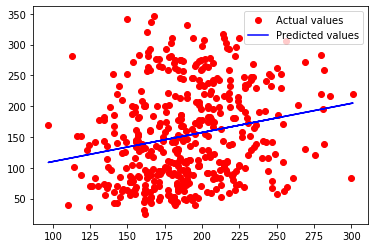

Regression coefficients w: [0.47230194]
Regression intercept b: 62.8021662163996
Mean squared error: 5663.315623739354


In [20]:
regression( x, y, [4], True)

In [22]:
regression( x, y, [4, 8])

Regression coefficients w: [-0.24177016 91.76831658]
Regression intercept b: -228.0725027816343
Mean squared error: 3979.7097540556524


In [37]:
with open( '../week4/sentiment-logistic-regression/sentiment_labelled_sentences/full_set.txt') as f:
    lines= f.readlines()
lines= [ line.strip() for line in lines]
x= [ line.split('\t')[0] for line in lines]
y= np.array( [ line.split('\t')[1] for line in lines], dtype= 'int8')*2 - 1

In [43]:
def full_remove(x, removal_list):
    for w in removal_list:
        x = x.replace(w, ' ')
    return x
digits = [str(x) for x in range(10)]
digit_less = [full_remove(i, digits) for i in x]
punc_less = [full_remove(x, list(string.punctuation)) for x in digit_less]
sents_lower = [x.lower() for x in punc_less]

In [46]:
bag= CountVectorizer( stop_words= 'english', max_features= 4000)
vectors= bag.fit_transform( sents_lower).toarray()

In [48]:
temp= np.ones(( vectors.shape[0], vectors.shape[1] + 1))
temp[ :, :-1]= vectors
vectors= temp

In [57]:
trainx, testx, trainy, testy= train_test_split( vectors, y, test_size=500)

In [58]:
trainx.shape, trainy.shape, testx.shape, testy.shape

((2500, 4001), (2500,), (500, 4001), (500,))

In [60]:
trainy

array([ 1, -1, -1, ..., -1, -1, -1], dtype=int8)

In [87]:
sgd_model= SGDClassifier( loss= 'log', penalty= 'none')
sgd_model.fit( trainx, trainy)
preds_train= sgd_model.predict( trainx)
preds_test= sgd_model.predict( testx)
error_train= np.sum( preds_train != trainy )/len(trainy)
error_test= np.sum( preds_test != testy)/len( testy)

print( 'Coefficients w: ' + str(sgd_model.coef_))
print( 'Bias term b: ' + str(sgd_model.intercept_))
print( 'Training error: ' + str(error_train))
print( 'Test error: ' + str(error_test))

Coefficients w: [[ 3.82775893e-03 -5.51205419e+00 -3.96456419e+00 ... -2.87669891e+00
  -4.60834636e+00 -8.38750647e-01]]
Bias term b: [-0.83875065]
Training error: 0.0132
Test error: 0.188


In [146]:
def show_margin( data, labels):
    preds= sgd_model.predict_proba( data)[:, 0]
    preds_binary= sgd_model.predict( data)
    length= len( labels)
    indices= lambda gamma: np.where( ( preds > 0.5 + gamma) | 
                                 ( preds < 0.5 - gamma))[0]
    counts= lambda gamma: len( indices( gamma))
    gammas= np.arange( 0, 0.5, 0.01)
    
    density= []
    errors= []
    for gamma in gammas:
        density.append( counts( gamma)/length)
        idx= indices( gamma)
        errors.append(np.sum( preds_binary[idx] != labels[ idx])/len(idx))
    
    plt.subplot(1,2,1).plot( gammas, density, 'r', label= 'Margin density')
    plt.legend()
    plt.subplot(1,2,2).plot( gammas, errors, 'g', label= 'Error rate')
    plt.legend()
    plt.show()

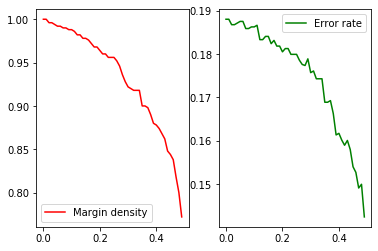

In [147]:
show_margin( testx, testy)

In [169]:
words= np.array( sorted(bag.vocabulary_.keys()))
coefficients= sgd_model.coef_
rank= np.argsort( coefficients)[0]
negatives= words[ rank[:20]]
positives= words[ rank[ -20:][::-1]]
print( 'Most positive words:')
print( positives)
print( '\nMost negative words:')
print( negatives)

Most positive words:
['nice' 'delicious' 'awesome' 'game' 'liked' 'perfectly' 'laptop' 'played'
 'appreciate' 'outstanding' 'joy' 'fine' 'works' 'loved' 'stories'
 'brilliant' 'incredible' 'excellent' 'great' 'beautiful']

Most negative words:
['poor' 'walked' 'pm' 'mediocre' 'rude' 'dirty' 'disappointment' 'guess'
 'avoid' 'terrible' 'waste' 'wasn' 'awful' 'bad' 'worst' 'stated' 'wouldn'
 'horrible' 'slow' 'useless']


In [229]:
def generate_data( n):
    w= np.array( [1]*10 + [0]*90)
    x= np.random.normal(size= (n,100))
    y= np.dot( w, x.T) + np.random.normal( size= n)
    return x, y

In [328]:
def ridge_regression_GD(x,y,C):
    lr= 0.001
    w= np.zeros( x.shape[1])
    b= 0
    loss_prev= 10**11
    loss_cur= 10**10
    losses= []
    while  ( loss_cur < loss_prev) | (len( losses) < 1000):
        loss_prev= loss_cur
        pred= np.dot( x, w) + b
        multiplier= [ (y[i] - pred[i])*x[i] for i in range( len(x))]
        multiplier= np.sum( np.array( multiplier), axis= 0)
        w= w - 2*lr*( C*w - multiplier) 
        b= b + 2*lr*np.sum( y - pred)
        loss_cur= np.sum(( y - pred)**2) + C*np.dot(w,w)
        losses.append( loss_cur)
    return w, b, losses

In [329]:
x,y = generate_data(200)
w, b, losses = ridge_regression_GD(x,y,1)
w.shape, b, len(losses)

((100,), 0.13372789049311914, 1000)

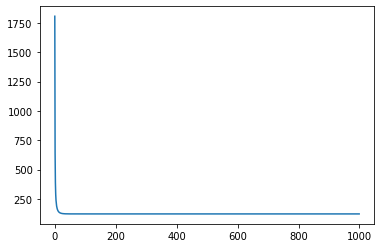

In [330]:
plt.plot( losses)

In [336]:
def compute_mse(w,b,x,y):
    residuals = y - (np.dot(x, w) + b)
    return np.dot(residuals, residuals)/len(y)

In [339]:
c= 10
w, b, losses = ridge_regression_GD(x,y,c)
model= linear_model.Ridge(alpha=c)
model.fit(x, y)
print ("MSE of gradient descent solver: ", compute_mse(w,b,x,y))
print ("MSE of built-in solver: ", mean_squared_error(model.predict(x), y))
print ("Distance between w-coefficients: ", np.linalg.norm(w-model.coef_))

MSE of gradient descent solver:  0.6116902605202761
MSE of built-in solver:  0.6116902605202761
Distance between w-coefficients:  4.756860550123179e-15


In [294]:
np.linalg.norm

ValueError: shapes (5,) and (2,5) not aligned: 5 (dim 0) != 2 (dim 0)

In [215]:
np.arange(5)+1

array([1, 2, 3, 4, 5])

In [197]:
y

array([-5.47224752, -0.49528055, -1.47789166, -0.16415634,  5.96211533,
        5.203761  , -3.00830535,  1.42336764,  0.45720978,  2.83264632,
       -2.30635152, -0.97130083, -0.28313111,  1.15650602,  0.08406757,
       -2.45524362,  0.45992804,  0.74877774, -0.43523314,  0.9412795 ,
       -0.03879633,  5.50468182, -1.84070347, -0.4123857 ,  0.13712393,
        0.41647372,  3.56187501, -4.41995194, -0.60256891,  2.4302438 ,
       -2.3917704 ,  2.77909361, -3.3507132 , -2.79936899, -6.30809253,
        2.43143279,  0.29371627,  5.2057177 , -4.52884437, -1.47153985,
       -1.52440833,  3.25192115,  2.11309307,  3.31495711, -4.57418683,
        2.29537964, -3.01508333, -2.72671574,  0.2578193 ,  7.1324219 ,
        1.31095756, -4.18031314, -3.7173464 , -0.97138442, -1.58144518,
        8.99424943, -1.82990065,  1.610574  ,  3.37979257, -3.93937362,
        1.01903379, -0.45600349, -3.92395325,  1.21418233,  1.21912875,
       -0.6716452 ,  6.25316063,  3.04409496,  6.73153409,  4.90

In [ ]:
plt.scatter()